In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
#utf-8: A popular encoding that supports many languages and is widely used on the web.
#latin1: Also known as ISO-8859-1, it supports Western European languages and is often used in older files.
#utf-16: Supports a wider range of characters, including many non-Latin scripts, but is less common in simple CSV files.
df=pd.read_csv('C:\\Users\\MSI PC\\Desktop\\Encryptix\\IMDb\\movie.csv',encoding='latin1')
df.head(5)

Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  
3  Siddhant Kapoor  
4      Antara Mali

## **E.D.A. & Missing Value Treatment**

In [3]:
print(df.describe().transpose(),'\n\n')
print(df.info())

         count      mean       std  min  25%  50%  75%   max
Rating  7919.0  5.841621  1.381777  1.1  4.9  6.0  6.8  10.0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB
None


In [4]:
print("unique count:")
print(df.nunique())
print("\n\nNull count:")
print(df.isnull().sum())

unique count:
Name        13838
Year          102
Duration      182
Genre         485
Rating         84
Votes        2034
Director     5938
Actor 1      4718
Actor 2      4891
Actor 3      4820
dtype: int64


Null count:
Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


In [5]:
def missing_values_percent(dataframe):
    m_v = dataframe.isna().sum()
    p_m = (m_v / len(dataframe) * 100).round(2)
    result_movie = pd.DataFrame({'Missing Values': m_v, 'Percentage%': p_m})
    return result_movie

result = missing_values_percent(df)
result

Missing Values  Percentage%
Name                   0         0.00
Year                 528         3.40
Duration            8269        53.32
Genre               1877        12.10
Rating              7590        48.94
Votes               7589        48.93
Director             525         3.39
Actor 1             1617        10.43
Actor 2             2384        15.37
Actor 3             3144        20.27

<Axes: ylabel='Percentage%'>

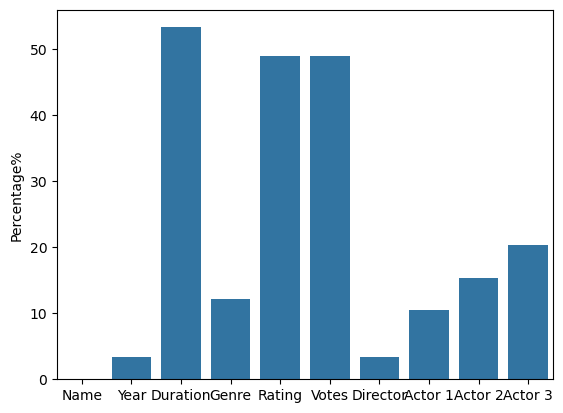

In [6]:
sns.barplot(result['Percentage%'])

Total no of Rated Movies= 7919
Number of outliers for Rating= 26


<Axes: ylabel='Rating'>

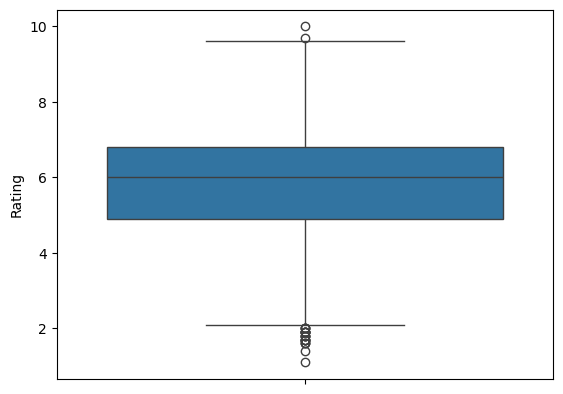

In [7]:
#Rating m.v.
def count_outliers(ser):
    Q1 = ser.quantile(0.25)
    Q3 = ser.quantile(0.75)
    IQR = Q3 - Q1
    l_b= Q1 - 1.5 * IQR
    u_b= Q3 + 1.5 * IQR
    outlier = ser[(ser < l_b) | (ser > u_b)]
    return len(outlier)

print('Total no of Rated Movies=',df['Rating'].value_counts().sum())
x = count_outliers(df['Rating'])
print("Number of outliers for Rating=",x)
sns.boxplot(df['Rating'])
#Number of outliers being to small so we can replace it with mean

In [8]:
df['Rating'].fillna(df['Rating'].mean())

0        5.841621
1        7.000000
2        5.841621
3        4.400000
4        5.841621
           ...   
15504    4.600000
15505    4.500000
15506    5.841621
15507    5.841621
15508    6.200000
Name: Rating, Length: 15509, dtype: float64

In [9]:
df=df.dropna(subset=['Year'],axis=0)
df['Year'].head(4)

1    (2019)
2    (2021)
3    (2019)
4    (2010)
Name: Year, dtype: object

In [10]:
df['Duration'] = df['Duration'].fillna('0').astype(str)
df['Duration'] = df['Duration'].str.replace(' min', '')
df['Duration'] = df['Duration'].astype(int)

In [11]:
print(max(df['Duration']))
print(min(df['Duration']))
print(np.mean(df['Duration']))
print(max(df['Duration']))

321
0
61.0137507509512
321


<Axes: xlabel='Duration'>

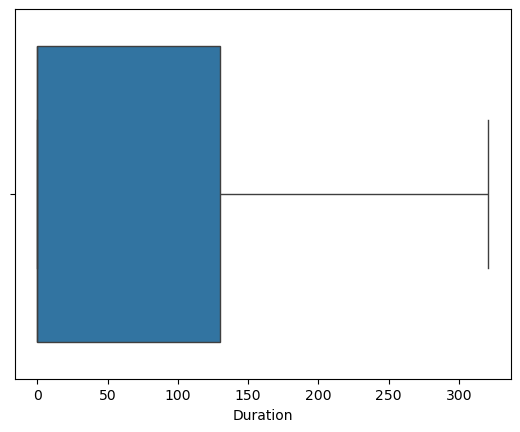

In [12]:
df['Duration']=df['Duration'].astype(int)
sns.boxplot(x=df['Duration'])


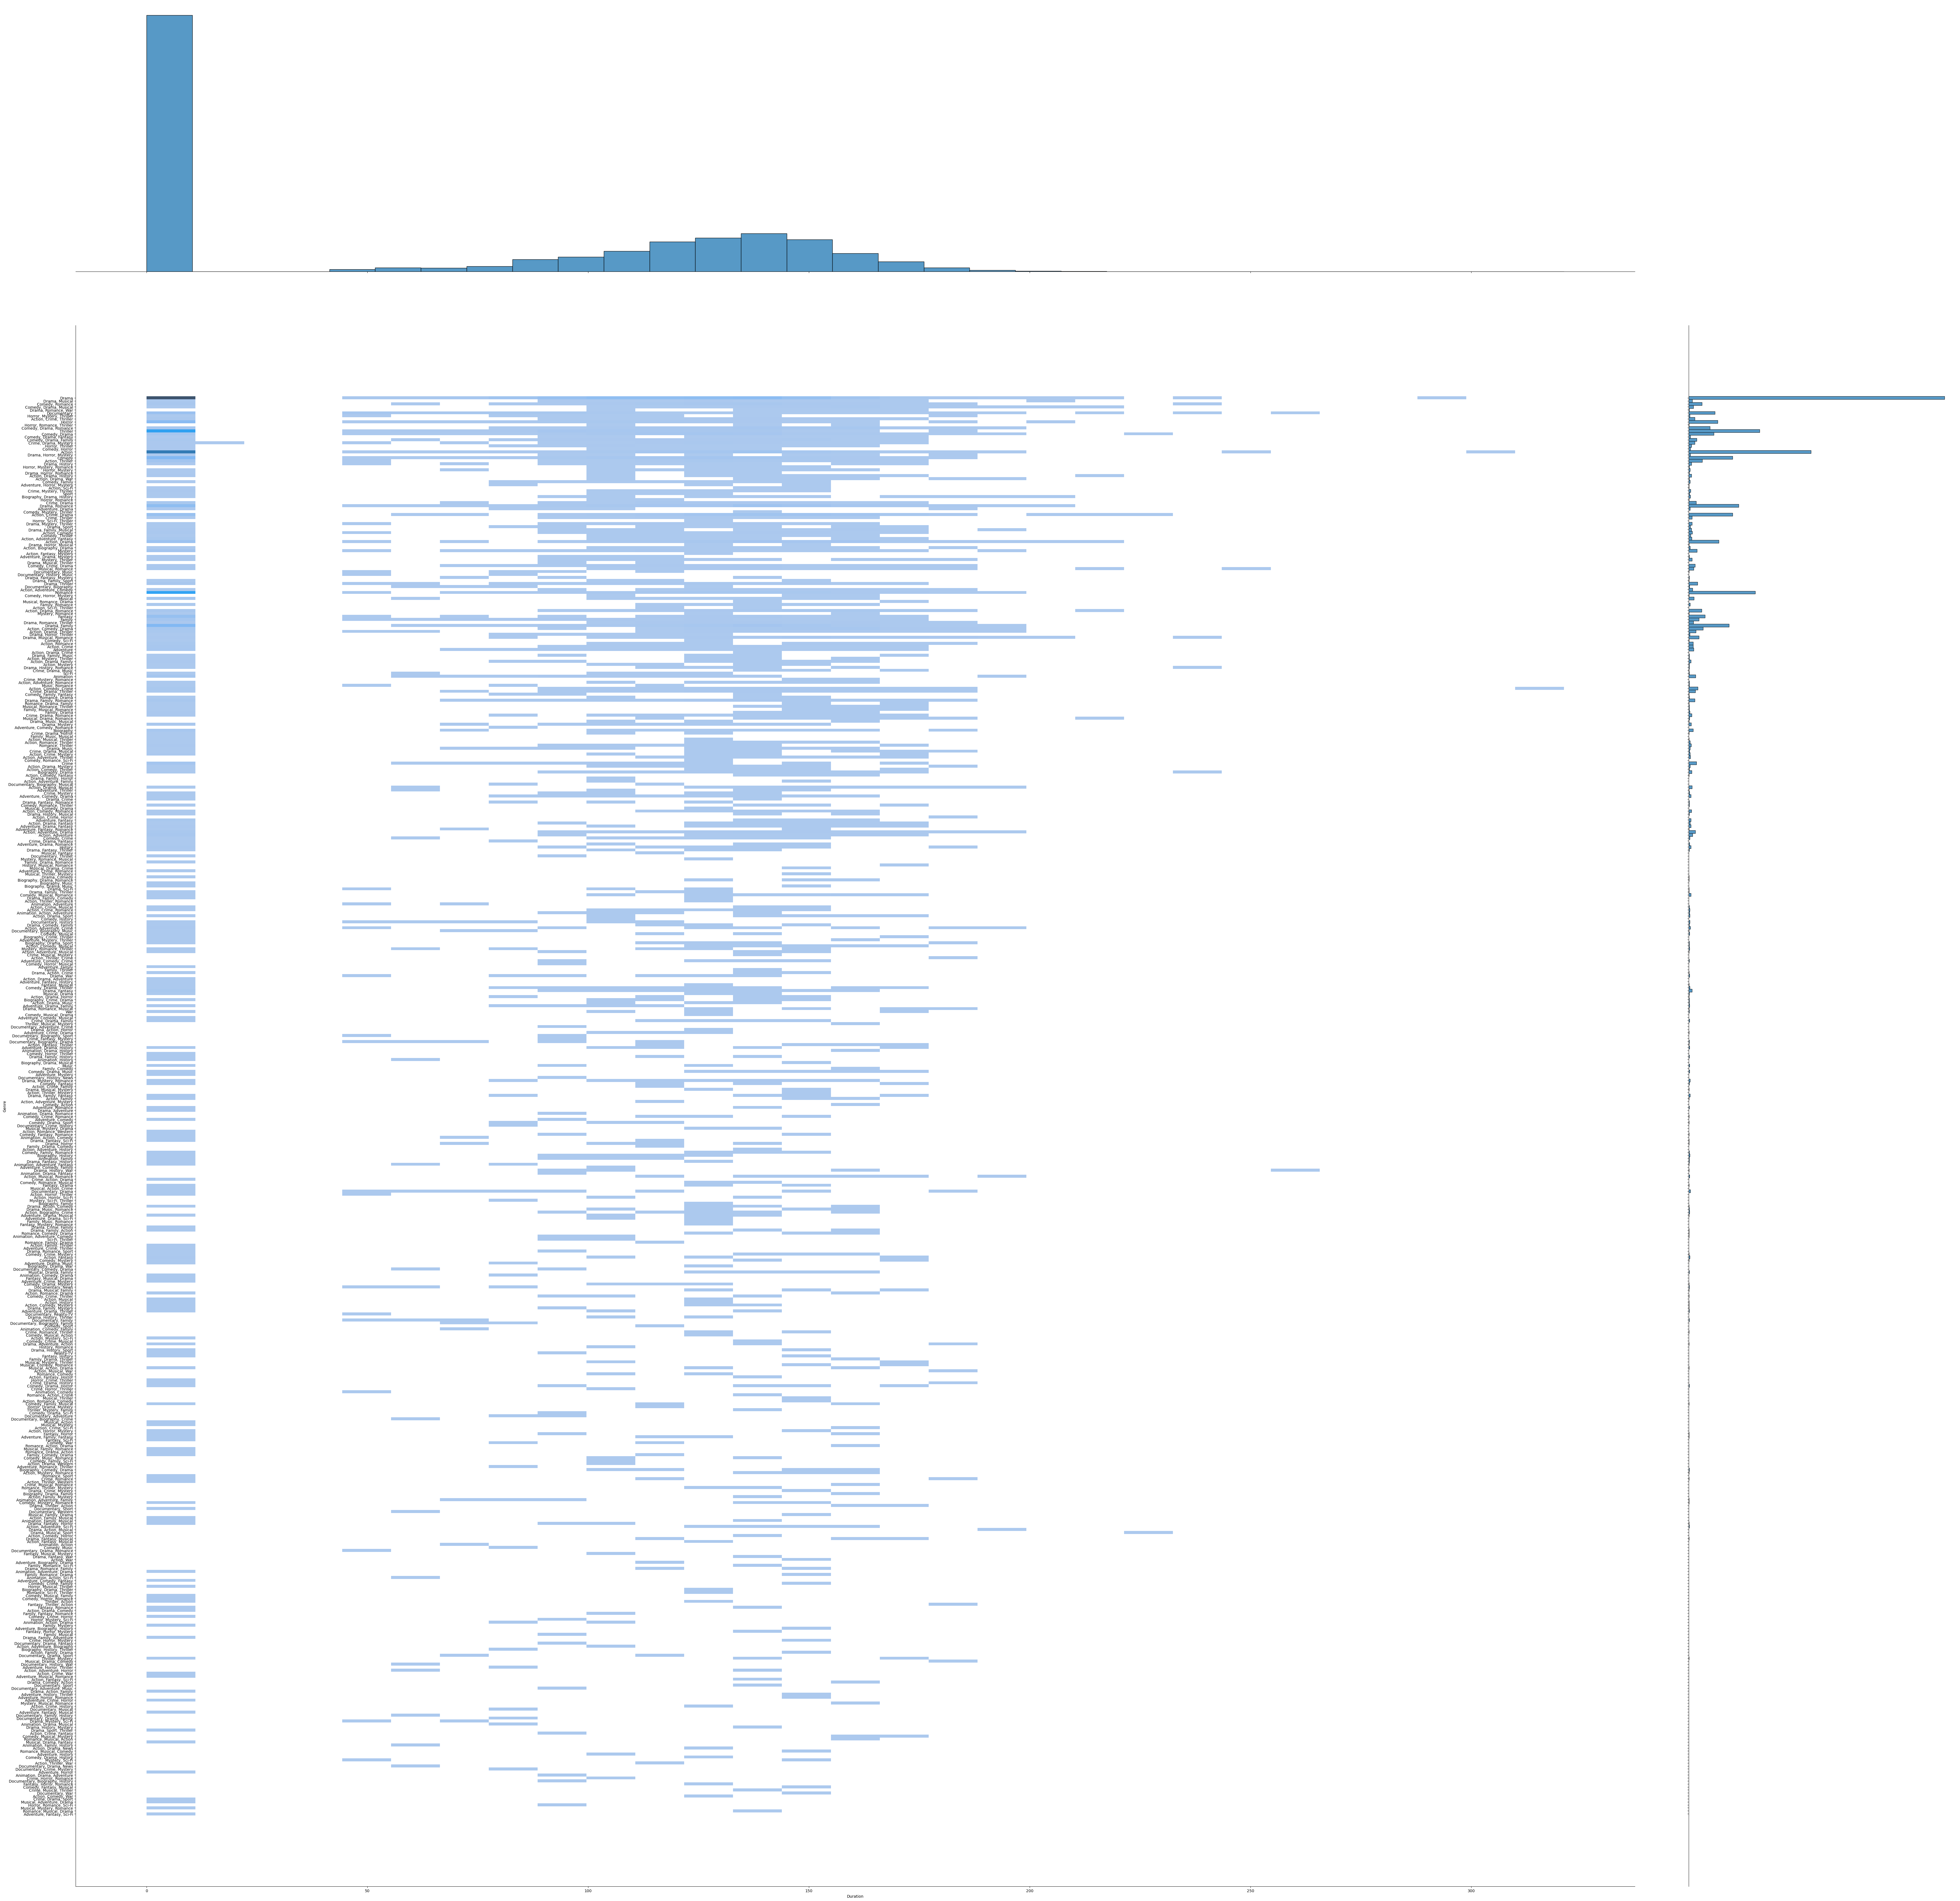

In [13]:
# plt.figure(figsize=(106, 10))
sns.jointplot(data=df, y='Genre', x='Duration',height=69,dropna=True,kind='hist')
plt.show()

Duration mainly depends on Genre , Actors name and Director

### Filling Nan values of Duration by Relating with Genre ,Actor and Director

In [14]:
median_duration_by_genre = df.groupby('Genre')['Duration'].median()

# Display median duration by genre
print("\nMedian duration by genre:")
print(median_duration_by_genre)

# Debug: Print rows with Duration == 0 before replacement
print("\nRows with Duration == 0 before replacement:")
print(df[df['Duration'] == 0])

# Replace Duration == 0 with median duration by genre inplace
for genre, median_duration in median_duration_by_genre.items():
    df.loc[(df['Duration'] == 0) & (df['Genre'] == genre), 'Duration'] = median_duration

# Debug: Print rows with Duration == 0 after replacement
print("\nRows with Duration == 0 after replacement:")
print(df['Duration'].value_counts())


Median duration by genre:
Genre
Action                            0.0
Action, Adventure                 0.0
Action, Adventure, Biography    100.0
Action, Adventure, Comedy       141.0
Action, Adventure, Crime         93.0
                                ...  
Thriller, Action                 64.5
Thriller, Musical, Mystery      158.0
Thriller, Mystery               139.0
Thriller, Mystery, Family       142.0
War                             100.0
Name: Duration, Length: 474, dtype: float64

Rows with Duration == 0 before replacement:
                      Name    Year  Duration                   Genre  Rating  \
14              101 Ratein  (1990)         0                Thriller     NaN   
17         108 Teerthyatra  (1987)         0  Comedy, Drama, Fantasy     NaN   
19              11 O'Clock  (1948)         0                     NaN     NaN   
20              12 Bulbule  (2021)         0   Comedy, Drama, Family     NaN   
24                    124a  (2021)         0             Doc

C:\Users\MSI PC\AppData\Local\Temp\ipykernel_12840\3399968982.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[(df['Duration'] == 0) & (df['Genre'] == genre), 'Duration'] = median_duration



Rows with Duration == 0 after replacement:
Duration
0.0      6258
135.0     299
120.0     282
121.0     243
57.0      235
         ... 
85.5        1
202.0       1
255.0       1
75.5        1
141.5       1
Name: count, Length: 213, dtype: int64


In [15]:

median_duration_by_director = df.groupby('Director')['Duration'].median()

# Replace Duration == 0 with median duration by Director inplace
for director, median_duration in median_duration_by_director.items():
    df.loc[(df['Duration'] == 0) & (df['Director'] == director), 'Duration'] = median_duration

print("\nCount of each Duration value:")
print(df['Duration'].value_counts())


Count of each Duration value:
Duration
0.0      5002
135.0     345
120.0     307
121.0     292
133.0     257
         ... 
85.5        1
202.0       1
255.0       1
75.5        1
29.0        1
Name: count, Length: 295, dtype: int64


In [16]:
actors=['Actor 1','Actor 2',  'Actor 3']
for actor in actors:
    median_duration_by_actor = df.groupby(actor)['Duration'].median()

    for act, median_duration in median_duration_by_actor.items():
        df.loc[(df['Duration'] == 0) & (df[actor] == act), 'Duration'] = median_duration
    print(f"\nCount of each Duration value: when grouping by {actor}")
    print(df['Duration'].value_counts())


Count of each Duration value: when grouping by Actor 1
Duration
0.00      3893
135.00     368
120.00     328
133.00     315
121.00     313
          ... 
159.50       1
126.25       1
247.00       1
211.00       1
76.50        1
Name: count, Length: 346, dtype: int64

Count of each Duration value: when grouping by Actor 2
Duration
0.000      2920
135.000     381
121.000     347
120.000     342
133.000     320
           ... 
29.625        1
2.000         1
107.500       1
223.000       1
76.500        1
Name: count, Length: 391, dtype: int64

Count of each Duration value: when grouping by Actor 3
Duration
0.00      2316
121.00     405
135.00     384
120.00     344
133.00     327
          ... 
25.50        1
247.00       1
79.50        1
15.75        1
76.50        1
Name: count, Length: 432, dtype: int64


321


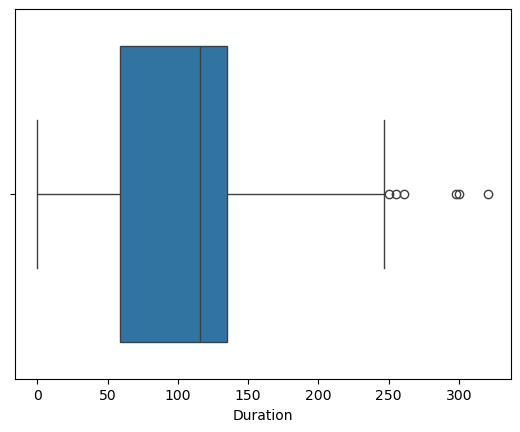

In [17]:
df['Duration']=df['Duration'].astype(int)
sns.boxplot(x=df['Duration'])
print(max(df['Duration']))

In [18]:
df=df.dropna(subset=['Duration'],axis=0)
df=df[df['Duration'] >= 60]
df.head()

Name    Year  Duration  \
1  #Gadhvi (He thought he was Gandhi)  (2019)       109   
2                         #Homecoming  (2021)        90   
3                             #Yaaram  (2019)       110   
4                   ...And Once Again  (2010)       105   
5                ...Aur Pyaar Ho Gaya  (1997)       147   

                    Genre  Rating Votes            Director       Actor 1  \
1                   Drama     7.0     8       Gaurav Bakshi  Rasika Dugal   
2          Drama, Musical     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   
3         Comedy, Romance     4.4    35          Ovais Khan       Prateik   
4                   Drama     NaN   NaN        Amol Palekar  Rajat Kapoor   
5  Comedy, Drama, Musical     4.7   827        Rahul Rawail    Bobby Deol   

                  Actor 2          Actor 3  
1          Vivek Ghamande    Arvind Jangid  
2       Plabita Borthakur       Roy Angana  
3              Ishita Raj  Siddhant Kapoor  
4      Rituparna Sengupta      Antara Mali  
5  Aishwarya Rai Bachchan    Shammi Kapoor

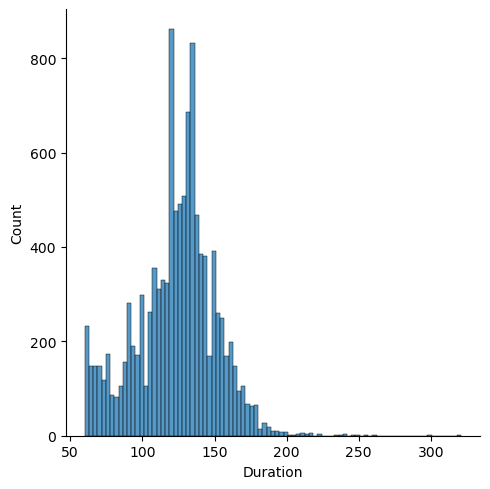

In [19]:
sns.displot(df['Duration'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11220 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      11220 non-null  object 
 1   Year      11220 non-null  object 
 2   Duration  11220 non-null  int32  
 3   Genre     10451 non-null  object 
 4   Rating    7525 non-null   float64
 5   Votes     7525 non-null   object 
 6   Director  11207 non-null  object 
 7   Actor 1   10912 non-null  object 
 8   Actor 2   10695 non-null  object 
 9   Actor 3   10371 non-null  object 
dtypes: float64(1), int32(1), object(8)
memory usage: 920.4+ KB


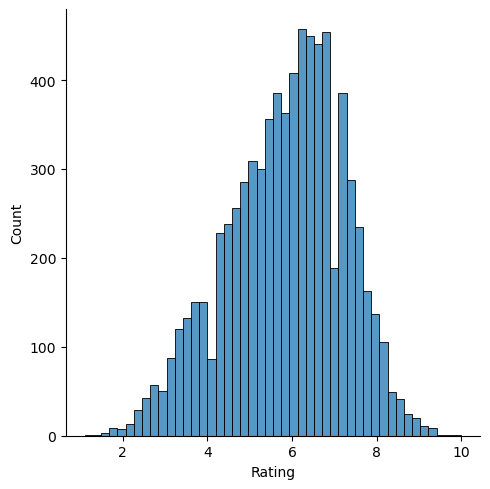

In [21]:
sns.displot(df['Rating'])

In [22]:
df=df.dropna(subset=['Rating'],axis=0)
result = missing_values_percent(df)
result

Missing Values  Percentage%
Name                   0         0.00
Year                   0         0.00
Duration               0         0.00
Genre                 65         0.86
Rating                 0         0.00
Votes                  0         0.00
Director               1         0.01
Actor 1               76         1.01
Actor 2              124         1.65
Actor 3              189         2.51

In [23]:
df["Director"]=df["Director"].fillna('Dilip Bose')

result = missing_values_percent(df)
result

Missing Values  Percentage%
Name                   0         0.00
Year                   0         0.00
Duration               0         0.00
Genre                 65         0.86
Rating                 0         0.00
Votes                  0         0.00
Director               0         0.00
Actor 1               76         1.01
Actor 2              124         1.65
Actor 3              189         2.51

In [24]:
## Genre missing value
df['Genre'] = df['Genre'].str.split(', ')
df = df.explode('Genre')
df['Genre'].fillna(df['Genre'].mode()[0], inplace=True)
df.head()

C:\Users\MSI PC\AppData\Local\Temp\ipykernel_12840\762182069.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Genre'].fillna(df['Genre'].mode()[0], inplace=True)


Name    Year  Duration    Genre  Rating  \
1  #Gadhvi (He thought he was Gandhi)  (2019)       109    Drama     7.0   
3                             #Yaaram  (2019)       110   Comedy     4.4   
3                             #Yaaram  (2019)       110  Romance     4.4   
5                ...Aur Pyaar Ho Gaya  (1997)       147   Comedy     4.7   
5                ...Aur Pyaar Ho Gaya  (1997)       147    Drama     4.7   

  Votes       Director       Actor 1                 Actor 2          Actor 3  
1     8  Gaurav Bakshi  Rasika Dugal          Vivek Ghamande    Arvind Jangid  
3    35     Ovais Khan       Prateik              Ishita Raj  Siddhant Kapoor  
3    35     Ovais Khan       Prateik              Ishita Raj  Siddhant Kapoor  
5   827   Rahul Rawail    Bobby Deol  Aishwarya Rai Bachchan    Shammi Kapoor  
5   827   Rahul Rawail    Bobby Deol  Aishwarya Rai Bachchan    Shammi Kapoor

In [25]:
df=df.dropna(subset=['Actor 1','Actor 2','Actor 3'],axis=0)
result = missing_values_percent(df)
result
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15074 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15074 non-null  object 
 1   Year      15074 non-null  object 
 2   Duration  15074 non-null  int32  
 3   Genre     15074 non-null  object 
 4   Rating    15074 non-null  float64
 5   Votes     15074 non-null  object 
 6   Director  15074 non-null  object 
 7   Actor 1   15074 non-null  object 
 8   Actor 2   15074 non-null  object 
 9   Actor 3   15074 non-null  object 
dtypes: float64(1), int32(1), object(8)
memory usage: 1.2+ MB


In [26]:
## Votes Missing Value
df['Votes'] = df['Votes'].str.replace(',', '', regex=False).astype(int)

In [27]:
df.head(10)

Name    Year  Duration    Genre  Rating  \
1  #Gadhvi (He thought he was Gandhi)  (2019)       109    Drama     7.0   
3                             #Yaaram  (2019)       110   Comedy     4.4   
3                             #Yaaram  (2019)       110  Romance     4.4   
5                ...Aur Pyaar Ho Gaya  (1997)       147   Comedy     4.7   
5                ...Aur Pyaar Ho Gaya  (1997)       147    Drama     4.7   
5                ...Aur Pyaar Ho Gaya  (1997)       147  Musical     4.7   
6                           ...Yahaan  (2005)       142    Drama     7.4   
6                           ...Yahaan  (2005)       142  Romance     7.4   
6                           ...Yahaan  (2005)       142      War     7.4   
8                  ?: A Question Mark  (2012)        82   Horror     5.6   

   Votes        Director          Actor 1                 Actor 2  \
1      8   Gaurav Bakshi     Rasika Dugal          Vivek Ghamande   
3     35      Ovais Khan          Prateik              Ishita Raj   
3     35      Ovais Khan          Prateik              Ishita Raj   
5    827    Rahul Rawail       Bobby Deol  Aishwarya Rai Bachchan   
5    827    Rahul Rawail       Bobby Deol  Aishwarya Rai Bachchan   
5    827    Rahul Rawail       Bobby Deol  Aishwarya Rai Bachchan   
6   1086  Shoojit Sircar  Jimmy Sheirgill          Minissha Lamba   
6   1086  Shoojit Sircar  Jimmy Sheirgill          Minissha Lamba   
6   1086  Shoojit Sircar  Jimmy Sheirgill          Minissha Lamba   
8    326   Allyson Patel        Yash Dave          Muntazir Ahmad   

           Actor 3  
1    Arvind Jangid  
3  Siddhant Kapoor  
3  Siddhant Kapoor  
5    Shammi Kapoor  
5    Shammi Kapoor  
5    Shammi Kapoor  
6   Yashpal Sharma  
6   Yashpal Sharma  
6   Yashpal Sharma  
8     Kiran Bhatia

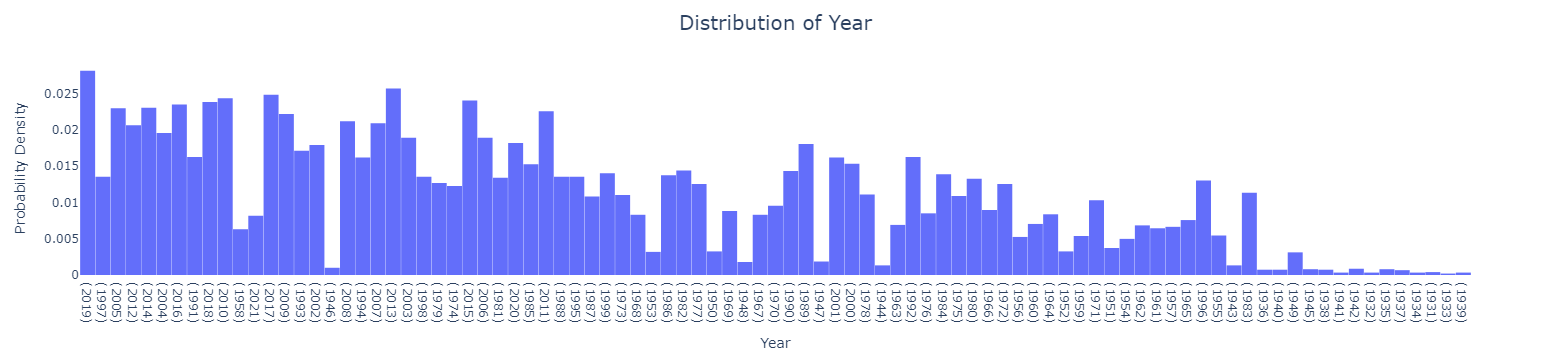

In [28]:
fig_year = px.histogram(df, x='Year', histnorm='probability density', nbins=30)
fig_year.update_traces(selector=dict(type='histogram'))
fig_year.update_layout(
    title='Distribution of Year',
    title_x=0.5,
    title_pad=dict(t=20),
    title_font=dict(size=20),
    xaxis_title='Year',
    yaxis_title='Probability Density',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    bargap=0.02,
    plot_bgcolor='white'
)

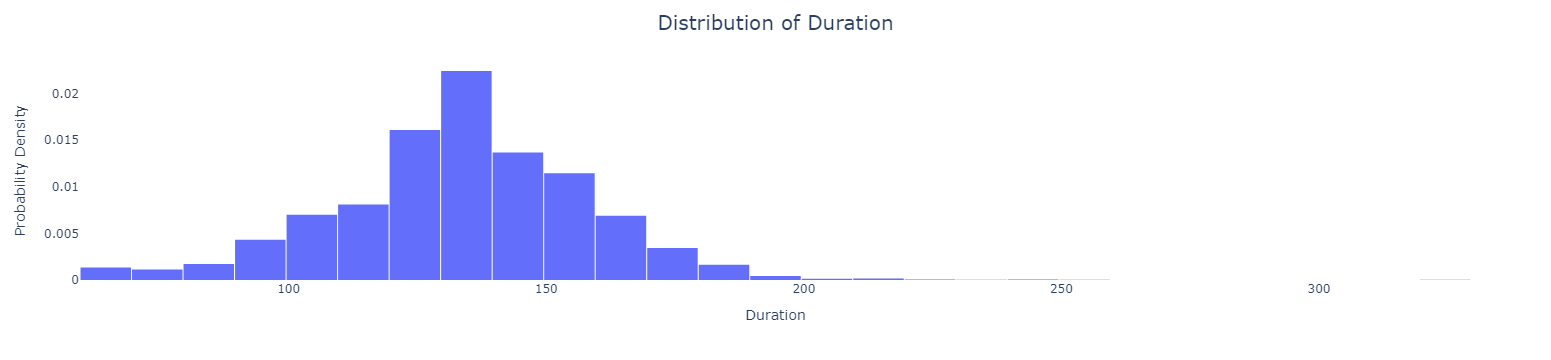

In [29]:
fig_dur = px.histogram(df, x = 'Duration', histnorm='probability density', nbins = 40)
fig_dur.update_traces(selector=dict(type='histogram'))
fig_dur.update_layout(
    title='Distribution of Duration', 
    title_x=0.5, title_pad=dict(t=20),
    title_font=dict(size=20), xaxis_title='Duration',
    yaxis_title='Probability Density',
    xaxis=dict(showgrid=False), 
    yaxis=dict(showgrid=False),
    bargap=0.02, 
    plot_bgcolor = 'white')
fig_dur.show()

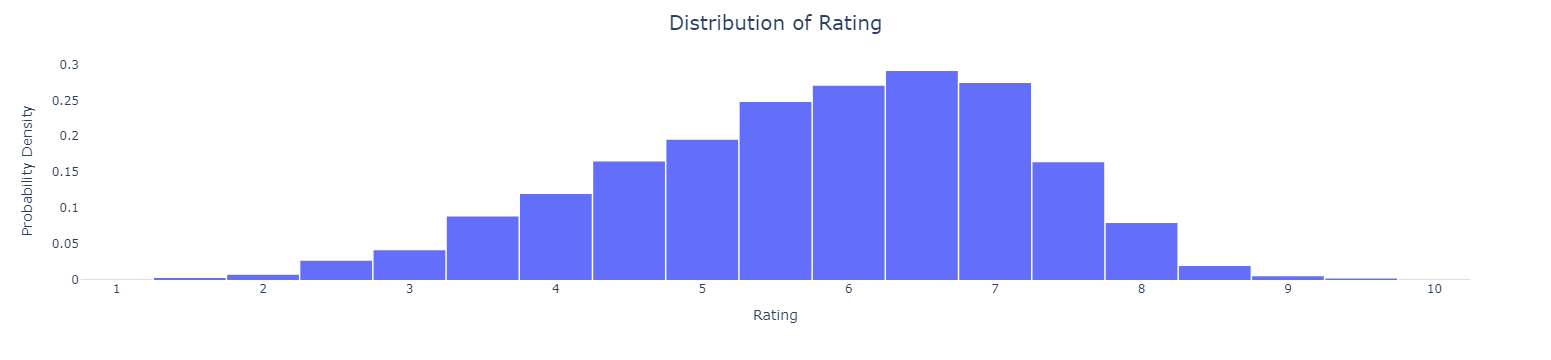

In [30]:
fig_rat = px.histogram(df, x = 'Rating', histnorm='probability density', nbins = 40)
fig_rat.update_traces(selector=dict(type='histogram'))
fig_rat.update_layout(title='Distribution of Rating', 
                      title_x=0.5, 
                      title_pad=dict(t=20),
                      title_font=dict(size=20),
                      xaxis_title='Rating',
                      yaxis_title='Probability Density',
                      xaxis=dict(showgrid=False),
                      yaxis=dict(showgrid=False),
                      bargap=0.02,
                      plot_bgcolor = 'white')
fig_rat.show()

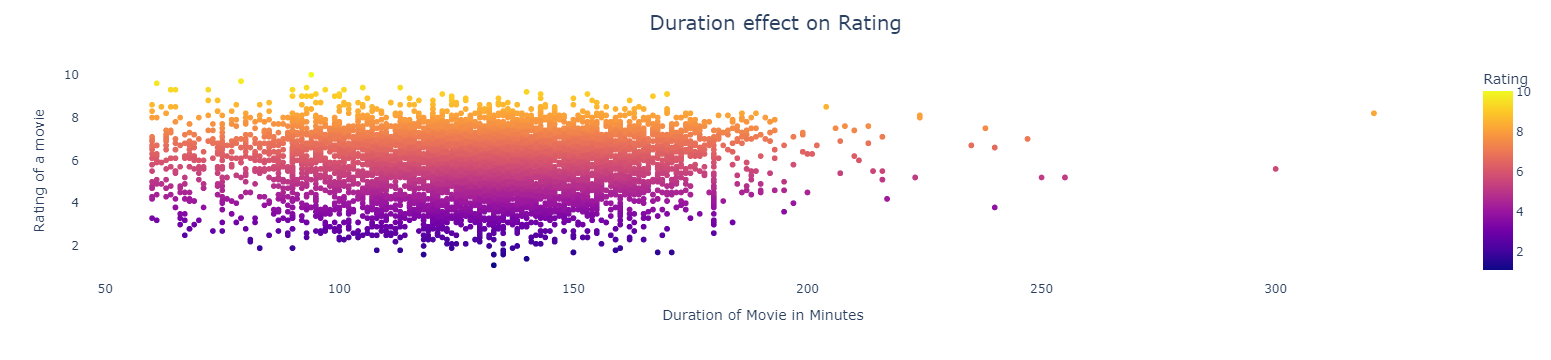

In [31]:
rel_dur_rat = px.scatter(df, x = 'Duration', y = 'Rating', color = "Rating")
rel_dur_rat.update_layout(title='Duration effect on Rating',
                          title_x=0.5,
                          title_pad=dict(t=20),
                          title_font=dict(size=20),
                          xaxis_title='Duration of Movie in Minutes',
                          yaxis_title='Rating of a movie',
                          xaxis=dict(showgrid=False), 
                          yaxis=dict(showgrid=False),
                          plot_bgcolor = 'white')
rel_dur_rat.show()

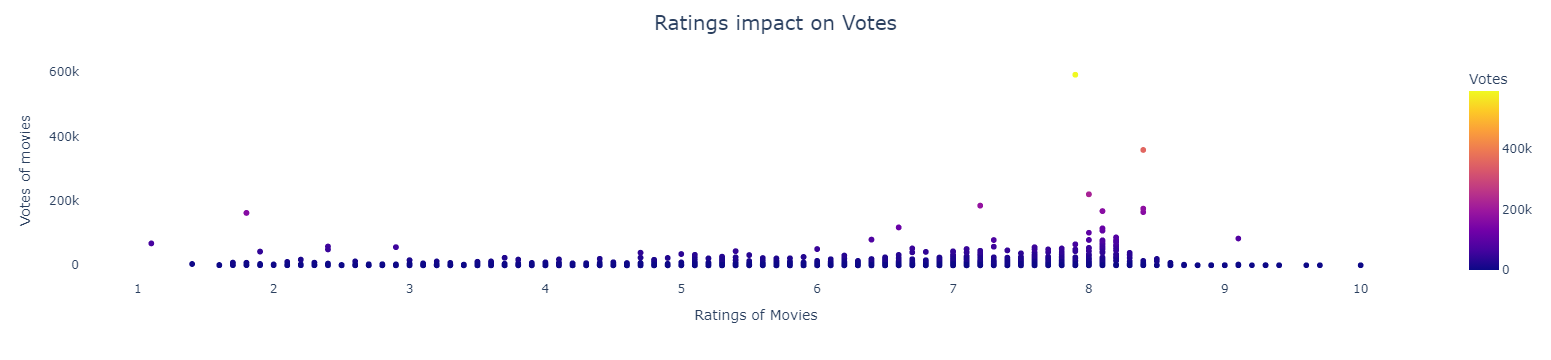

In [32]:
fig_rat_votes = px.scatter(df, x = 'Rating', y = 'Votes', color = "Votes")
fig_rat_votes.update_layout(title='Ratings impact on Votes ',
                            title_x=0.5, 
                            title_pad=dict(t=20), 
                            title_font=dict(size=20), 
                            xaxis_title='Ratings of Movies', 
                            yaxis_title='Votes of movies', 
                            xaxis=dict(showgrid=False), 
                            yaxis=dict(showgrid=False),
                            plot_bgcolor = 'white')
fig_rat_votes.show()


In [33]:
df.drop('Name', axis = 1, inplace = True)

In [34]:
#Correcting date format
df=df.dropna(subset=['Year'],axis=0)
df['Year'].head()
df['Year'] = df['Year'].str.replace('(', '', regex=False).str.replace(')', '', regex=False).astype(int)

df.head()

Year  Duration    Genre  Rating  Votes       Director       Actor 1  \
1  2019       109    Drama     7.0      8  Gaurav Bakshi  Rasika Dugal   
3  2019       110   Comedy     4.4     35     Ovais Khan       Prateik   
3  2019       110  Romance     4.4     35     Ovais Khan       Prateik   
5  1997       147   Comedy     4.7    827   Rahul Rawail    Bobby Deol   
5  1997       147    Drama     4.7    827   Rahul Rawail    Bobby Deol   

                  Actor 2          Actor 3  
1          Vivek Ghamande    Arvind Jangid  
3              Ishita Raj  Siddhant Kapoor  
3              Ishita Raj  Siddhant Kapoor  
5  Aishwarya Rai Bachchan    Shammi Kapoor  
5  Aishwarya Rai Bachchan    Shammi Kapoor

## Feature Engineering 

In [35]:
g_mean_rat = df.groupby('Genre')['Rating'].transform('mean')
df['G_mean_rat'] = g_mean_rat

dir_mean_rat = df.groupby('Director')['Rating'].transform('mean')
df['Dir_enc'] = dir_mean_rat

a1_mean_rat = df.groupby('Actor 1')['Rating'].transform('mean')
df['A1_enc'] = a1_mean_rat

a2_mean_rat = df.groupby('Actor 2')['Rating'].transform('mean')
df['A2_enc'] = a2_mean_rat

a3_mean_rat = df.groupby('Actor 3')['Rating'].transform('mean')
df['A3_enc'] = a3_mean_rat

In [36]:
df.head(5)

Year  Duration    Genre  Rating  Votes       Director       Actor 1  \
1  2019       109    Drama     7.0      8  Gaurav Bakshi  Rasika Dugal   
3  2019       110   Comedy     4.4     35     Ovais Khan       Prateik   
3  2019       110  Romance     4.4     35     Ovais Khan       Prateik   
5  1997       147   Comedy     4.7    827   Rahul Rawail    Bobby Deol   
5  1997       147    Drama     4.7    827   Rahul Rawail    Bobby Deol   

                  Actor 2          Actor 3  G_mean_rat   Dir_enc    A1_enc  \
1          Vivek Ghamande    Arvind Jangid    5.987941  7.000000  6.850000   
3              Ishita Raj  Siddhant Kapoor    5.726592  4.400000  5.250000   
3              Ishita Raj  Siddhant Kapoor    5.749141  4.400000  5.250000   
5  Aishwarya Rai Bachchan    Shammi Kapoor    5.726592  5.342105  4.793617   
5  Aishwarya Rai Bachchan    Shammi Kapoor    5.987941  5.342105  4.793617   

   A2_enc  A3_enc  
1    7.00    7.00  
3    4.40    4.46  
3    4.40    4.46  
5    5.73    5.93  
5    5.73    5.93

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15074 entries, 1 to 15508
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        15074 non-null  int32  
 1   Duration    15074 non-null  int32  
 2   Genre       15074 non-null  object 
 3   Rating      15074 non-null  float64
 4   Votes       15074 non-null  int32  
 5   Director    15074 non-null  object 
 6   Actor 1     15074 non-null  object 
 7   Actor 2     15074 non-null  object 
 8   Actor 3     15074 non-null  object 
 9   G_mean_rat  15074 non-null  float64
 10  Dir_enc     15074 non-null  float64
 11  A1_enc      15074 non-null  float64
 12  A2_enc      15074 non-null  float64
 13  A3_enc      15074 non-null  float64
dtypes: float64(6), int32(3), object(5)
memory usage: 1.6+ MB


## Model Deployment

In [38]:
X = df[[ 'Year','Votes', 'Duration', 'G_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc']]
y = df['Rating']
print(X.shape)
print(y.shape)

(15074, 8)
(15074,)


In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2)

## (1) Linear Regression

In [40]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [41]:
print('The performance evaluation of Linear Regression is below:')
print('Mean squared error:', metrics.mean_squared_error(y_test, lr_pred))
print('Mean absolute error:', metrics.mean_absolute_error(y_test, lr_pred))
print('R2 score:', metrics.r2_score(y_test, lr_pred))
print('\n', '='*100, '\n')

cv_scores_lr = cross_val_score(lr, X, y, cv=8, scoring='r2')
print('Linear Regression 5-fold cross-validation R2 scores:', cv_scores_lr)
print('Mean R2 score:', cv_scores_lr.mean())

The performance evaluation of Linear Regression is below:
Mean squared error: 0.4140951393205695
Mean absolute error: 0.47974855335269584
R2 score: 0.758133677132174


Linear Regression 5-fold cross-validation R2 scores: [0.74580968 0.7178191  0.75935159 0.7381327  0.76971803 0.74521424
 0.71236289 0.7704389 ]
Mean R2 score: 0.7448558901375664


## (2)Decision Tree Regression

In [42]:
dt_regressor = DecisionTreeRegressor(random_state=2)
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)

In [43]:
print('The performance evaluation of Decision Tree Regressor is below:')
print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred))
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('R2 score:', metrics.r2_score(y_test, y_pred))

cv_scores_dt = cross_val_score(dt_regressor, X, y, cv=8, scoring='r2')
print('\nDecision Tree Regressor 5-fold cross-validation R2 scores:', cv_scores_dt)
print('Mean R2 score:', cv_scores_dt.mean())

The performance evaluation of Decision Tree Regressor is below:
Mean squared error: 0.09157824933687002
Mean absolute error: 0.09031830238726801
R2 score: 0.9465106147874037

Decision Tree Regressor 5-fold cross-validation R2 scores: [0.51989674 0.53861423 0.55166213 0.56860252 0.59365443 0.55561806
 0.55839896 0.60298134]
Mean R2 score: 0.5611785495019856


In [44]:
print('The performance evaluation of Decision Tree Regressor is below:')
print('Mean squared error:', metrics.mean_squared_error(y_test, y_pred))
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('R2 score:', metrics.r2_score(y_test, y_pred))

cv_scores_dt = cross_val_score(dt_regressor, X, y, cv=8, scoring='r2')
print('\nDecision Tree Regressor 5-fold cross-validation R2 scores:', cv_scores_dt)
print('Mean R2 score:', cv_scores_dt.mean())

The performance evaluation of Decision Tree Regressor is below:
Mean squared error: 0.09157824933687002
Mean absolute error: 0.09031830238726801
R2 score: 0.9465106147874037

Decision Tree Regressor 5-fold cross-validation R2 scores: [0.51989674 0.53861423 0.55166213 0.56860252 0.59365443 0.55561806
 0.55839896 0.60298134]
Mean R2 score: 0.5611785495019856


## (3) Random Forest Regression

In [45]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [46]:
print('The performance evaluation of Random Forest Regressor is below:')
print('Mean squared error:', metrics.mean_squared_error(y_test, rf_pred))
print('Mean absolute error:', metrics.mean_absolute_error(y_test, rf_pred))
print('R2 score:', metrics.r2_score(y_test, rf_pred))

cv_scores_rf = cross_val_score(rf, X, y, cv=8, scoring='r2')
print('\nRandom Forest Regressor 5-fold cross-validation R2 scores:', cv_scores_rf)
print('Mean R2 score:', cv_scores_rf.mean())

The performance evaluation of Random Forest Regressor is below:
Mean squared error: 0.07835164588859415
Mean absolute error: 0.16215384615384631
R2 score: 0.9542360615176269

Random Forest Regressor 5-fold cross-validation R2 scores: [0.78706661 0.74543393 0.78872453 0.79600802 0.82667834 0.79803862
 0.74554569 0.81210808]
Mean R2 score: 0.787450478893797


In [47]:
Featured_df = df.copy()
Featured_df.to_csv('Featured_df.csv', index=False)

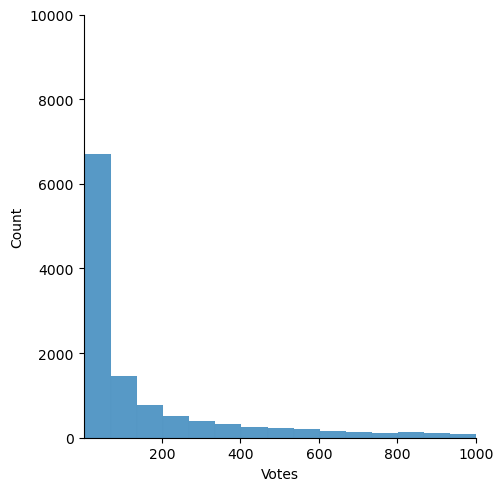

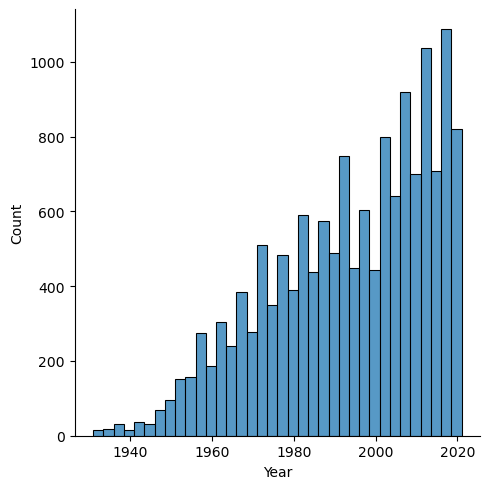

In [48]:
sns.displot(df['Votes'])
plt.xlim(1, 1000)  
plt.ylim(0, 10000) 
plt.show()
sns.displot(df['Year'])

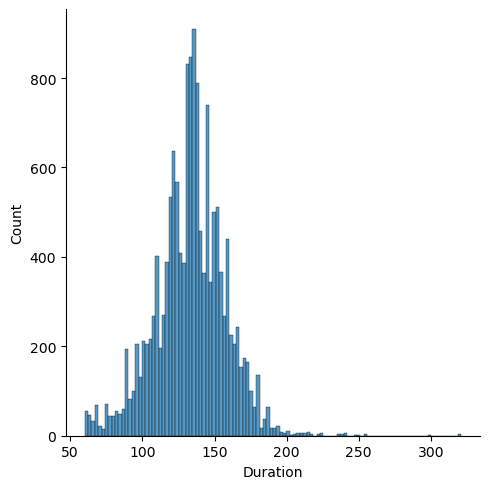

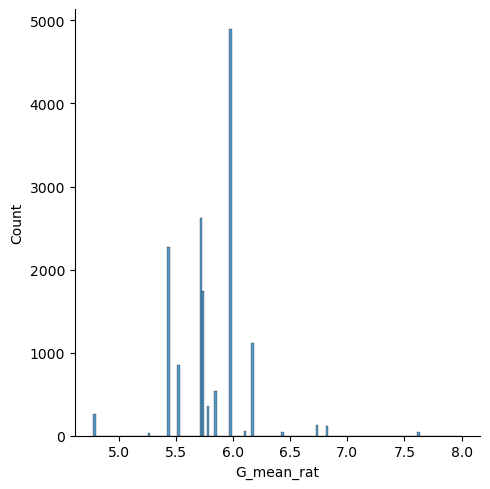

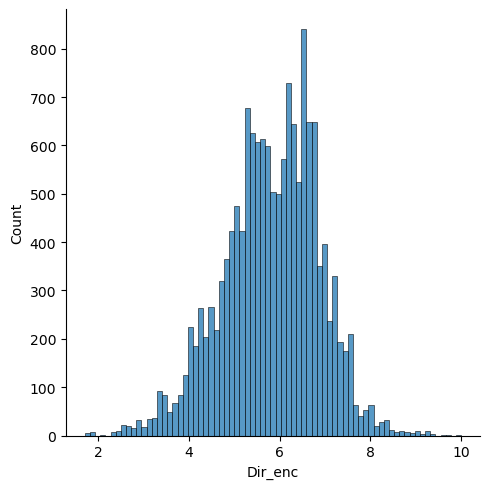

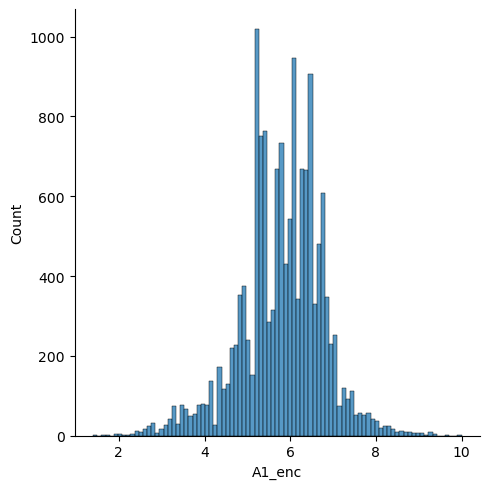

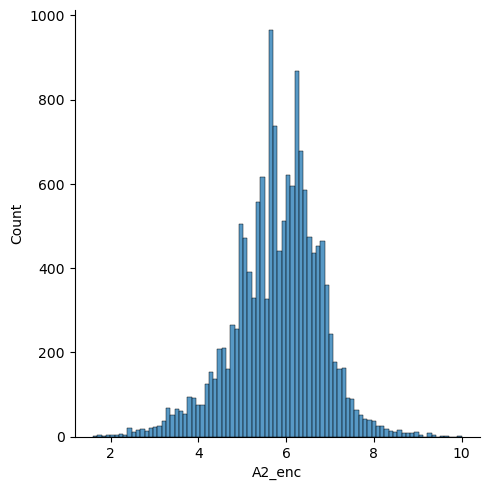

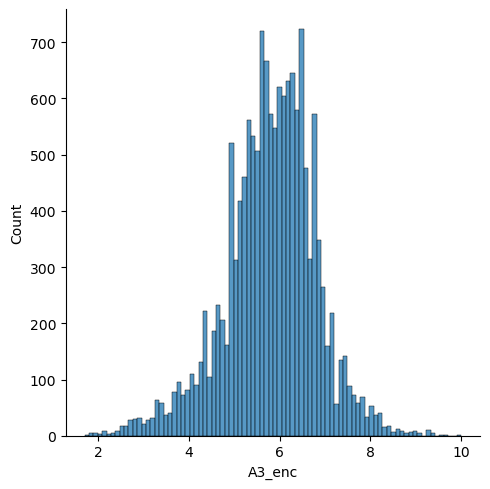

In [49]:
xol=[ 'Duration', 'G_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc']
for x in xol:
    sns.displot(df[x])

In [50]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(df[['Duration', 'G_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc']])
std_df=pd.DataFrame(columns=[ 'Duration', 'G_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc'],data=x_scaled)
minmax=MinMaxScaler()
x_minmax=minmax.fit_transform(df[['Year','Votes']])
minmax_df = pd.DataFrame(data=x_minmax, columns=['Year', 'Votes'])
scaled_df = pd.concat([std_df, minmax_df], axis=1)
scaled_df.head()

Duration  G_mean_rat   Dir_enc    A1_enc    A2_enc    A3_enc      Year  \
0 -0.992384    0.599667  1.129951  1.070762  1.204433  1.186219  0.977778   
1 -0.951469   -0.260612 -1.330095 -0.569883 -1.417770 -1.336731  0.977778   
2 -0.951469   -0.186389 -1.330095 -0.569883 -1.417770 -1.336731  0.977778   
3  0.562401   -0.260612 -0.438702 -1.037860 -0.076412  0.123401  0.733333   
4  0.562401    0.599667 -0.438702 -1.037860 -0.076412  0.123401  0.733333   

      Votes  
0  0.000005  
1  0.000051  
2  0.000051  
3  0.001390  
4  0.001390

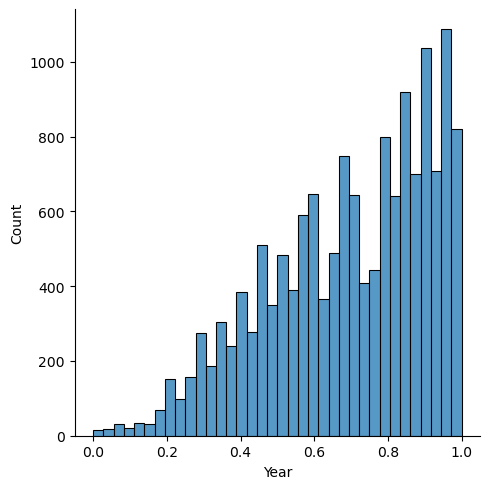

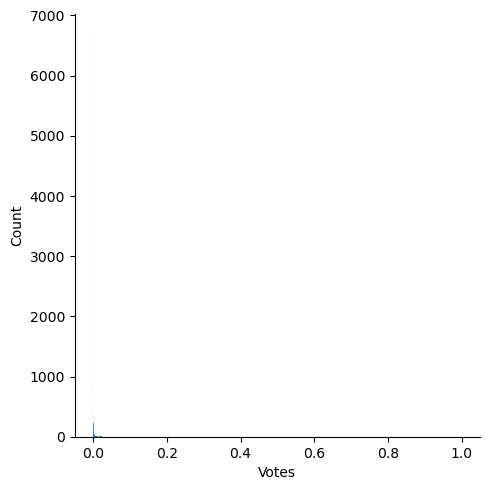

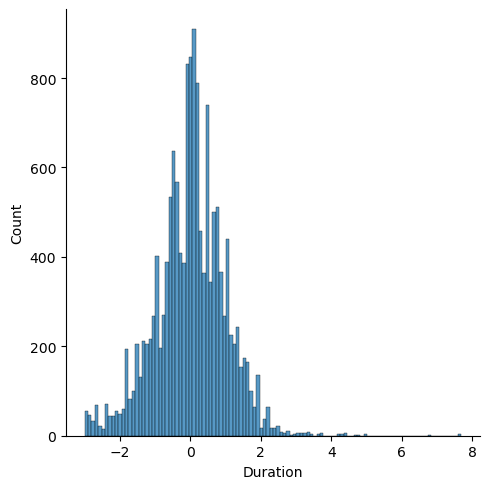

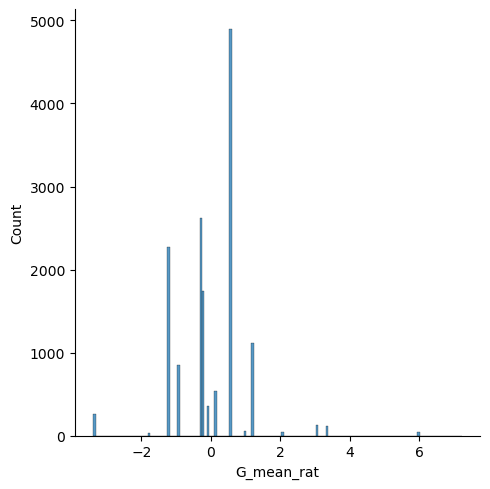

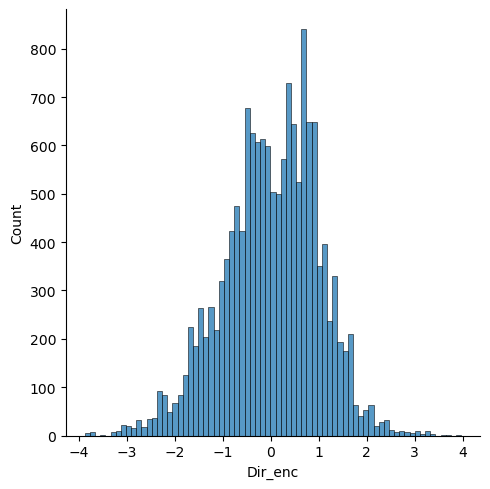

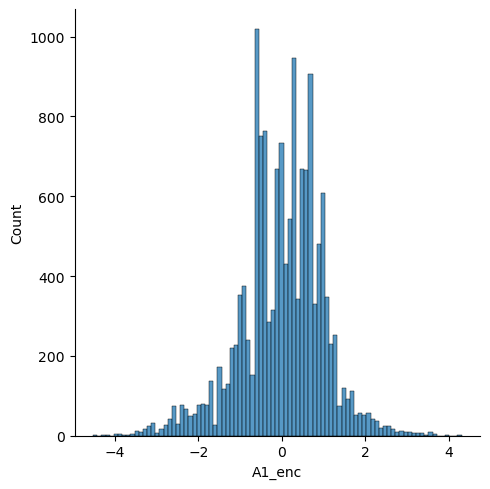

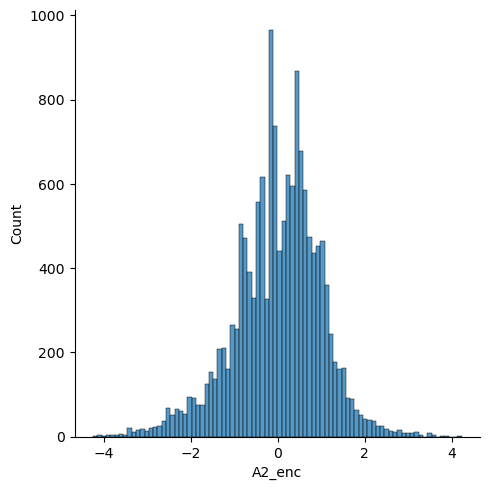

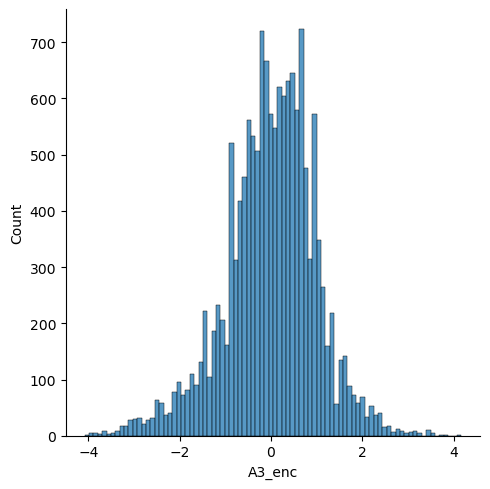

In [51]:
xol=['Year','Votes', 'Duration', 'G_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc']
for x in xol:
    sns.displot(scaled_df[x])

In [52]:
X = df[['Year', 'Votes', 'Duration', 'G_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc']]
y=df['Rating']

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.info()

(13566, 8)
(13566,)
(1508, 8)
(1508,)
<class 'pandas.core.frame.DataFrame'>
Index: 13566 entries, 7839 to 7320
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        13566 non-null  int32  
 1   Votes       13566 non-null  int32  
 2   Duration    13566 non-null  int32  
 3   G_mean_rat  13566 non-null  float64
 4   Dir_enc     13566 non-null  float64
 5   A1_enc      13566 non-null  float64
 6   A2_enc      13566 non-null  float64
 7   A3_enc      13566 non-null  float64
dtypes: float64(5), int32(3)
memory usage: 794.9 KB


In [54]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [55]:
print('The performance evaluation of Linear Regression is below:')
print('Mean squared error:', metrics.mean_squared_error(y_test, lr_pred))
print('Mean absolute error:', metrics.mean_absolute_error(y_test, lr_pred))
print('R2 score:', metrics.r2_score(y_test, lr_pred))
print('\n', '='*100, '\n')

cv_scores_lr = cross_val_score(lr, X, y, cv=8, scoring='r2')
print('Linear Regression 5-fold cross-validation R2 scores:', cv_scores_lr)
print('Mean R2 score:', cv_scores_lr.mean())

The performance evaluation of Linear Regression is below:
Mean squared error: 0.4140951393205695
Mean absolute error: 0.47974855335269584
R2 score: 0.758133677132174


Linear Regression 5-fold cross-validation R2 scores: [0.74580968 0.7178191  0.75935159 0.7381327  0.76971803 0.74521424
 0.71236289 0.7704389 ]
Mean R2 score: 0.7448558901375664


In [56]:
dt_regressor = DecisionTreeRegressor(random_state=2)
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)


In [57]:
print('The performance evaluation of Decision Tree Regressor is below: ', '\n')
print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
cv_scores_dt = cross_val_score(dt_regressor, X, y, cv=8, scoring='r2')
print('\nDecision Tree Regressor 5-fold cross-validation R2 scores:', cv_scores_dt)
print('Mean R2 score:', cv_scores_dt.mean())

The performance evaluation of Decision Tree Regressor is below:  

Mean squared error:  0.09157824933687002
Mean absolute error:  0.09031830238726801
R2 score:  0.9465106147874037

Decision Tree Regressor 5-fold cross-validation R2 scores: [0.51989674 0.53861423 0.55166213 0.56860252 0.59365443 0.55561806
 0.55839896 0.60298134]
Mean R2 score: 0.5611785495019856


In [58]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [59]:
print('The performance evaluation of Decision Tree Regressor is below: ', '\n')
print('Mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('Mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('R2 score: ', metrics.r2_score(y_test, y_pred))
cv_scores_dt = cross_val_score(dt_regressor, X, y, cv=8, scoring='r2')
print('\nDecision Tree Regressor 5-fold cross-validation R2 scores:', cv_scores_dt)
print('Mean R2 score:', cv_scores_dt.mean())

The performance evaluation of Decision Tree Regressor is below:  

Mean squared error:  0.09157824933687002
Mean absolute error:  0.09031830238726801
R2 score:  0.9465106147874037

Decision Tree Regressor 5-fold cross-validation R2 scores: [0.51989674 0.53861423 0.55166213 0.56860252 0.59365443 0.55561806
 0.55839896 0.60298134]
Mean R2 score: 0.5611785495019856


In [ ]:
print('The performance evaluation of Random Forest Regressor is below: ', '\n')
print('Mean squared error: ',metrics.mean_squared_error(y_test, rf_pred))
print('Mean absolute error: ',metrics.mean_absolute_error(y_test, rf_pred))
print('R2 score: ',metrics.r2_score(y_test, rf_pred))
cv_scores_rf = cross_val_score(rf, X, y, cv=8, scoring='r2')
print('\nRandom Forest Regressor 5-fold cross-validation R2 scores:', cv_scores_rf)
print('Mean R2 score:', cv_scores_rf.mean())

The performance evaluation of Random Forest Regressor is below:  

Mean squared error:  0.08025184681697616
Mean absolute error:  0.1624953580901858
R2 score:  0.9531261846617626


 **In terms of comparison Random Forest Regression is best. Followed by Decision Tree Regression & Linear Regression.**